In [1]:
# prediction interval for mlps on the housing regression dataset
from numpy import asarray
import numpy as np
import pandas as pd
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam



In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = read_csv('lstm_data.csv').drop('Unnamed: 0', axis=1)
df.head().T

,0,1,2,3,4
engine,1.0000,1.0000,1.0000,1.0000,1.0000
cycle,1.0000,2.0000,3.0000,4.0000,5.0000
setting_1,-0.0007,0.0019,-0.0043,0.0007,-0.0019
setting_2,-0.0004,-0.0003,0.0003,0.0000,-0.0002
(LPC outlet temperature) (◦R),641.8200,642.1500,642.3500,642.3500,642.3700
(HPC outlet temperature) (◦R),1589.7000,1591.8200,1587.9900,1582.7900,1582.8500
(LPT outlet temperature) (◦R),1400.6000,1403.1400,1404.2000,1401.8700,1406.2200
(bypass-duct pressure) (psia),21.6100,21.6100,21.6100,21.6100,21.6100
(HPC outlet pressure) (psia),554.3600,553.7500,554.2600,554.4500,554.0000
(Physical fan speed) (rpm),2388.0600,2388.0400,2388.0800,2388.1100,2388.0600


In [4]:
train_data = df[df["engine"]<=80]
cal_data = df[(df["engine"]>80)&(df["engine"]<=90)]
test_data = df[df["engine"]>90]

In [5]:
features_col_name = df.columns[:-1]
target_col_name = df.columns[-1]

In [6]:
X_train = train_data.copy()
X_test = test_data.copy()
X_cal = cal_data.copy()

In [7]:
sc=MinMaxScaler()
X_train[features_col_name] = sc.fit_transform(X_train[features_col_name])
X_test[features_col_name] = sc.transform(X_test[features_col_name])
X_cal[features_col_name] = sc.transform(X_cal[features_col_name])

In [8]:
#function for features
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length,id_df.shape[1])), columns=id_df.columns)
    # id_df=df_zeros.append(id_df,ignore_index=True)
    id_df = pd.concat([df_zeros, id_df], ignore_index=True)

    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# function to generate labels
def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length,id_df.shape[1])), columns= id_df.columns)
    # id_df=df_zeros.append(id_df,ignore_index=True)
    id_df = pd.concat([df_zeros, id_df], ignore_index=True)

    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [9]:
# timestamp or window size
seq_length=50
seq_cols=features_col_name

In [10]:
X_Train=gen_sequence(X_train, seq_length, seq_cols)
print(X_Train.shape)
# generate y_train
y_train=gen_label(X_train, seq_length, seq_cols, label='RUL')
print(y_train.shape)

(16138, 50, 18)
(16138,)


In [11]:
X_Cal=gen_sequence(X_cal, seq_length, seq_cols)
print(X_Cal.shape)
# generate y_train
y_cal=gen_label(X_cal, 50, seq_cols,'RUL')
print(y_cal.shape)

(2242, 50, 18)
(2242,)


In [12]:
X_Test=gen_sequence(X_test, seq_length, seq_cols)
print(X_Test.shape)
# generate y_train
y_test=gen_label(X_test, 50, seq_cols,'RUL')
print(y_test.shape)

(2251, 50, 18)
(2251,)


In [13]:
X_train =X_Train
X_test = X_Test
y_train =y_train
y_test = y_test

In [55]:
# yhat = [model.predict(X, verbose=0) for model in ensemble]

NameError: name 'X' is not defined

In [61]:
# load and prepare the dataset
# def load_dataset(url):
# 	dataframe = read_csv(url)
# 	# values = dataframe.values
# 	# split into input and output values
# 	X, y = dataframe.iloc[ :-1], dataframe.iloc[-1]
# 	# split into train and test sets
# 	X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.67, random_state=1)
# 	# scale input data
# 	scaler = MinMaxScaler()
# 	scaler.fit(X_train)
# 	X_train = scaler.transform(X_train)
# 	X_test = scaler.transform(X_test)
# 	return X_train, X_test, y_train, y_test

# define and fit the model
# def fit_model(X_train, y_train):
# 	# define neural network model
# 	features = X_train.shape[1]
# 	model = Sequential()
# 	model.add(Dense(20, kernel_initializer='he_normal', activation='relu', input_dim=features))
# 	model.add(Dense(5, kernel_initializer='he_normal', activation='relu'))
# 	model.add(Dense(1))
# 	# compile the model and specify loss and optimizer
# 	opt = Adam(learning_rate=0.01, beta_1=0.85, beta_2=0.999)
# 	model.compile(optimizer=opt, loss='mse')
# 	# fit the model on the training dataset
# 	model.fit(X_train, y_train, verbose=0, epochs=300, batch_size=16)
# 	return model

# callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
def fit_model(X_Train, y_train):
    model = Sequential([
        layers.LSTM(128, input_shape = (X_Train.shape[1], X_Train.shape[2]), return_sequences=True, activation = "tanh"),
        layers.LSTM(64, activation = "tanh", return_sequences = True),
        layers.LSTM(32, activation = "tanh"),
        layers.Dense(96, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    model.fit(X_Train, y_train, epochs = 20,
                    # validation_data = (X_Test, y_test),
                    # callbacks = callback,
                    batch_size = 128, verbose = 2)
    return model

# fit an ensemble of models
def fit_ensemble(n_members, X_train, X_test, y_train, y_test):
	ensemble = list()
	y_predi =[]
	for i in range(n_members):
		# define and fit the model on the training set
		model = fit_model(X_train, y_train)
		# evaluate model on the test set
		yhat = model.predict(X_test, verbose=0)

		mae = mean_absolute_error(y_test, yhat)
		print('>%d, MAE: %.3f' % (i+1, mae))
		# store the model
		ensemble.append(model)
		y_predi.append(yhat)
	return ensemble, y_predi

# make predictions with the ensemble and calculate a prediction interval
def predict_with_pi(ensemble, X, y_pred):
	# make predictions
	yhat = [model.predict(X, verbose=0) for model in ensemble]
	yhat = asarray(yhat)
	# calculate 95% gaussian prediction interval
	# interval = 1.96 * yhat.std()
	interval =  1.04 * y_pred[0].std()
	lower  = yhat.mean() - interval +37.707607
	upper = yhat.mean() + interval-37.707607
	return lower, yhat.mean(), upper

# load dataset
# url = 'lstm_data.csv'
# X_train, X_test, y_train, y_test = load_dataset(url)
# fit ensemble
n_members = 1
ensemble, y_pred = fit_ensemble(n_members, X_train, X_test, y_train, y_test)
# make predictions with prediction interval
newX = asarray([X_test[0, :]])
lower, mean, upper = predict_with_pi(ensemble, newX, y_pred)
print('Point prediction: %.3f' % mean)
print('95%% prediction interval: [%.3f, %.3f]' % (lower, upper))
print('True value: %.3f' % y_test[0])

Epoch 1/20
127/127 - 26s - loss: 4071.6416 - 26s/epoch - 203ms/step
Epoch 2/20
127/127 - 19s - loss: 1743.5341 - 19s/epoch - 147ms/step
Epoch 3/20
127/127 - 18s - loss: 1745.3065 - 18s/epoch - 141ms/step
Epoch 4/20
127/127 - 18s - loss: 1745.0403 - 18s/epoch - 142ms/step
Epoch 5/20
127/127 - 18s - loss: 1746.3560 - 18s/epoch - 140ms/step
Epoch 6/20
127/127 - 18s - loss: 1744.0454 - 18s/epoch - 138ms/step
Epoch 7/20
127/127 - 18s - loss: 1742.9670 - 18s/epoch - 140ms/step
Epoch 8/20
127/127 - 18s - loss: 827.4774 - 18s/epoch - 141ms/step
Epoch 9/20
127/127 - 18s - loss: 375.9938 - 18s/epoch - 139ms/step
Epoch 10/20
127/127 - 18s - loss: 252.6590 - 18s/epoch - 139ms/step
Epoch 11/20
127/127 - 18s - loss: 233.4945 - 18s/epoch - 140ms/step
Epoch 12/20
127/127 - 18s - loss: 206.5638 - 18s/epoch - 139ms/step
Epoch 13/20
127/127 - 18s - loss: 184.2007 - 18s/epoch - 138ms/step
Epoch 14/20
127/127 - 18s - loss: 187.0104 - 18s/epoch - 142ms/step
Epoch 15/20
127/127 - 18s - loss: 176.2014 - 18s/e

In [54]:
y_pred[0].std()

37.707607

In [49]:
newX = asarray([X_test[2, :]])
lower, mean, upper = predict_with_pi(ensemble, newX)
print('Point prediction: %.3f' % mean)
print('95%% prediction interval: [%.3f, %.3f]' % (lower, upper))
print('True value: %.3f' % y_test[2])

Point prediction: 124.462
95% prediction interval: [124.462, 124.462]
True value: 125.000


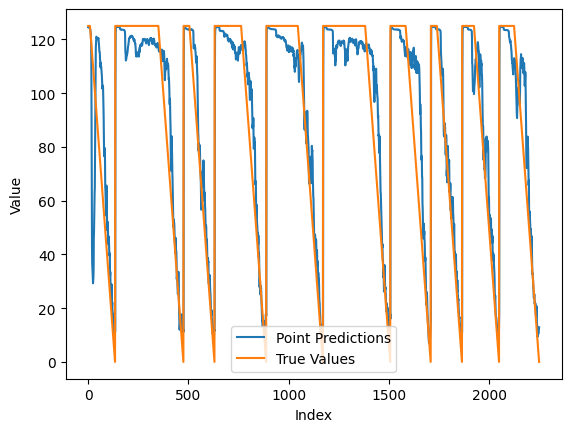

In [47]:
import matplotlib.pyplot as plt

# create empty arrays for point predictions and true values
point_preds = []
true_vals = []

# loop through test points and make predictions
for i in range(len(X_test)):
    newX = asarray([X_test[i, :]])
    lower, mean, upper = predict_with_pi(ensemble, newX)
    point_preds.append(mean)
    true_vals.append(y_test[i])

# create plot with point predictions and true values
fig, ax = plt.subplots()
ax.plot(range(len(X_test)), point_preds, label='Point Predictions')
ax.plot(range(len(X_test)), true_vals, label='True Values')
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.legend()

# show plot
plt.show()


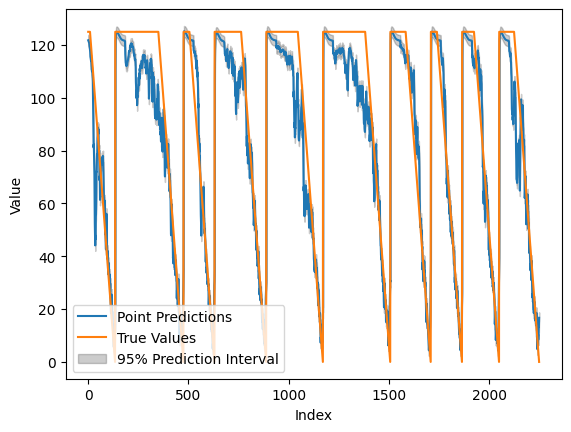

In [63]:
import matplotlib.pyplot as plt

# create empty arrays for point predictions, true values, and prediction intervals
point_preds = []
true_vals = []
lower_bounds = []
upper_bounds = []

# loop through test points and make predictions
for i in range(len(X_test)):
    newX = asarray([X_test[i, :]])
    lower, mean, upper = predict_with_pi(ensemble, newX,y_pred)
    point_preds.append(mean)
    true_vals.append(y_test[i])
    lower_bounds.append(lower)
    upper_bounds.append(upper)

# create plot with point predictions, true values, and prediction intervals
fig, ax = plt.subplots()
ax.plot(range(len(X_test)), point_preds, label='Point Predictions')
ax.plot(range(len(X_test)), true_vals, label='True Values')
ax.fill_between(range(len(X_test)), lower_bounds, upper_bounds, alpha=0.2, label='95% Prediction Interval', color='black')
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.legend()

# show plot
plt.show()


ValueError: x and y must have same first dimension, but have shapes (2251,) and (4502,)

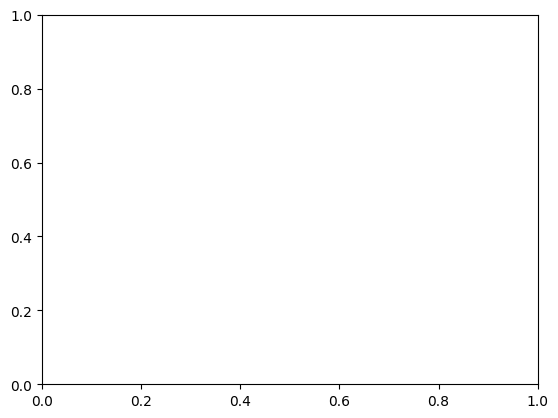

In [64]:
for i in range(len(X_test)):
    newX = asarray([X_test[i, :]])
    lower, mean, upper = predict_with_pi(ensemble, newX,y_pred)
    point_preds.append(mean)
    true_vals.append(y_test[i])
    lower_bounds.append(lower)
    upper_bounds.append(upper)

# create plot with point predictions, true values, and prediction intervals
fig, ax = plt.subplots()
ax.plot(range(len(X_test)), point_preds, label='Point Predictions')
ax.plot(range(len(X_test)), true_vals, label='True Values')
ax.fill_between(range(len(X_test)), lower_bounds, upper_bounds, alpha=0.2, label='95% Prediction Interval', color='red')
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.legend()

# show plot
plt.show()

In [22]:
for i in range(len(X_test)):
    newX = asarray([X_test[i, :]])
    lower, mean, upper = predict_with_pi(ensemble, newX)
    print('Point prediction for point %d: %.3f' % (i, mean))
    print('95%% prediction interval for point %d: [%.3f, %.3f]' % (i, lower, upper))
    print('True value for point %d: %.3f\n' % (i, y_test[i]))


Point prediction for point 0: 122.472
95% prediction interval for point 0: [122.472, 122.472]
True value for point 0: 125.000

Point prediction for point 1: 119.760
95% prediction interval for point 1: [119.760, 119.760]
True value for point 1: 125.000

Point prediction for point 2: 114.349
95% prediction interval for point 2: [114.349, 114.349]
True value for point 2: 125.000

Point prediction for point 3: 103.201
95% prediction interval for point 3: [103.201, 103.201]
True value for point 3: 125.000

Point prediction for point 4: 86.542
95% prediction interval for point 4: [86.542, 86.542]
True value for point 4: 125.000

Point prediction for point 5: 73.997
95% prediction interval for point 5: [73.997, 73.997]
True value for point 5: 125.000

Point prediction for point 6: 55.300
95% prediction interval for point 6: [55.300, 55.300]
True value for point 6: 125.000

Point prediction for point 7: 51.292
95% prediction interval for point 7: [51.292, 51.292]
True value for point 7: 125.0